# Imports


In [1]:
# Do this or put the code/notebook directly in the same directory as 'splineop' 
import sys
sys.path.append("../")
# Imports
from splineop import splineop as spop
from scipy.interpolate import make_lsq_spline
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
def compute_prediction(signal_noisy, bkps):
    n_samples = signal_noisy.shape[0]
    x = np.linspace(0, 1, n_samples, False)
    b = np.array(bkps)
    b = b[(b > 0) & (b < n_samples)] # remove end points
    t = np.hstack(
    (np.array([0, 0, 0]), b / n_samples)
    ) # add triple starting point for smoothing
    t = np.hstack((t, np.array([1, 1, 1]))) # add triple end point for smoothing
    lsq_poly = make_lsq_spline(x=x, y=signal_noisy, t=t, k=2) # Fit polynomial
    yhat = lsq_poly(x)
    return yhat, lsq_poly

In [3]:
from numpy.polynomial import Polynomial

def construct_quadratic(x0, y0, x1, y1, v0):
    """
    Constructs a quadratic polynomial P(x) such that:
      - P(x0) = y0
      - P(x1) = y1
      - P'(x0) = v0

    Returns:
        A function P(x)
    """
    if x1 == x0:
        raise ValueError("x0 and x1 must be different to define a quadratic")

    # Compute coefficients
    a = (y1 - y0 - v0 * (x1 - x0)) / (x1 - x0)**2
    b = v0 - 2 * a * x0
    c = y0 + a * x0**2 - v0 * x0
    return Polynomial([c, b, a])


In [4]:
def plot_approx_of_op(signal, bkps, v):
    n_samples = signal.shape[0]
    bkps_with_ends = [0] + bkps + [n_samples]
    for start, end in zip(bkps_with_ends[:-1], bkps_with_ends[1:]):
        p = construct_quadratic(
            x0=start/n_samples, 
            y0=signal[start, 0], 
            x1=end/n_samples, 
            y1=signal[min(end, n_samples-1), 0], 
            v0=v
        )
        v = p.deriv()(end/n_samples)
        x = np.linspace(start/n_samples, end/n_samples, 100, False)
        plt.plot(x, p(x), "--")

# Load data

In [5]:
signal = np.array([ 0., 0.97476548,  1.51702549,  1.62678003,  1.30402909,  0.54877269,
 -0.35488727, -0.82099054, -0.83178075, -0.38725791,  0.51257799,  1.68843677,
  2.40323668,  2.57729317,  2.21060627,  1.30317596, -0.05752466, -1.06236943,
 -1.51454388, -1.41404801, -0.76088183,  0.42311414,  1.41720274,  1.87193562,
  1.78731279])[:, None]


signal = np.arange(20)[:, None]
signal[5] = 0

signal = np.random.normal(0, 1, size=(20, 1))

signal = np.array([-0.5538366539852463, 1.520330843452079, 1.1568464380607646, -0.25672386834360117, 0.26701022014941883, -0.5569015163824721, 0.0039023732192848977, 0.6135816949729489, 0.17853854922169188, -0.6581326650081704, 1.1408804695045343, -0.7188644543380338, 0.22858566413113388, 0.14886327051604423, -0.6444699435164172, -1.2341416612965999, 0.1060960066797375, 0.68842074334761, -1.4347055296533557, -1.8131734620286035])[:, None]
signal.shape

(20, 1)

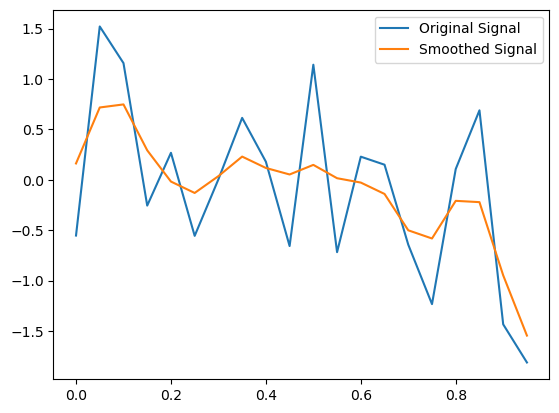

In [6]:
from scipy.ndimage import gaussian_filter1d
x = np.linspace(0, 1, signal.shape[0], False)
# Apply a Gaussian filter to smooth the signal
smoothed_signal = gaussian_filter1d(signal.squeeze(), sigma=1)[:, None]
plt.plot(x, signal.squeeze(), label="Original Signal")
plt.plot(x, smoothed_signal.squeeze(), label="Smoothed Signal")
plt.legend()
plt.show()

# General usage 

In [15]:
# Define a cost and model
cost = spop.costConstrained()
model = spop.splineOPConstrained(cost)

# Generarte states and speeds from observed data
states = spop.state_generator(signal, n_states=20, pct=1)[..., None]
# states = np.empty((signal.shape[0]+1, 1, 1))
# states[:signal.shape[0]] = signal[:, None]
# states[-1] = states[-2]  # Last state is the same as the second last
# speeds = spop.compute_speeds_from_observations(signal)
speeds = np.array([[30]])
# Pre-compute quantities used in cost function
model.fit(signal, 
        states,
        speeds, 
        True)

# Compute costs and backtrack solution
model.predict(2)

 n_bkps = 1	Residual norm: 3.1105  (OK)
 n_bkps = 2	Residual norm: 2.8230  (OK)
 n_bkps = 3	Residual norm: 2.5973  (OK)
 n_bkps = 4	Residual norm: 2.4359  (OK)
 n_bkps = 5	Residual norm: 2.1061  (OK)
 n_bkps = 6	Residual norm: 2.0985  (OK)
 n_bkps = 7	Residual norm: 1.8740  (OK)
 n_bkps = 8	Residual norm: 1.8559  (OK)
 n_bkps = 9	Residual norm: 1.8559  (OK)
 n_bkps = 10	Residual norm: 1.7047  (OK)
 n_bkps = 11	Residual norm: 1.3280  (OK)
 n_bkps = 12	Residual norm: 1.2452  (OK)
 n_bkps = 13	Residual norm: 1.2153  (OK)
 n_bkps = 14	Residual norm: 1.1807  (OK)
 n_bkps = 15	Residual norm: 0.4159  (OK)
 n_bkps = 16	Residual norm: 0.0885  (OK)
 n_bkps = 17	Residual norm: 0.0000  (OK)


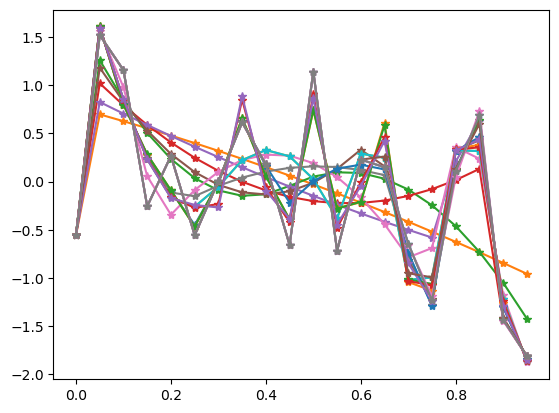

In [16]:
x = np.linspace(0, 1, signal.shape[0], False)
plt.plot(x, signal, "-*", label="Observed Signal")

old_error = np.inf
for n_bkps in range(1, signal.shape[0] - 2):
    model.predict(n_bkps)
    approx, spl = compute_prediction(signal, model.bkps)
    residual_norm = np.linalg.norm(signal - approx)

    print(f"{ n_bkps = }\tResidual norm: {residual_norm:.4f} {' (OK)' if residual_norm < old_error else 'Worse than previous'}")
    old_error = residual_norm
    plt.plot(x, approx, "-*", label="Approximation")


 n_bkps = 2	Residual norm: 2.8835
Breakpoints: [2 8]


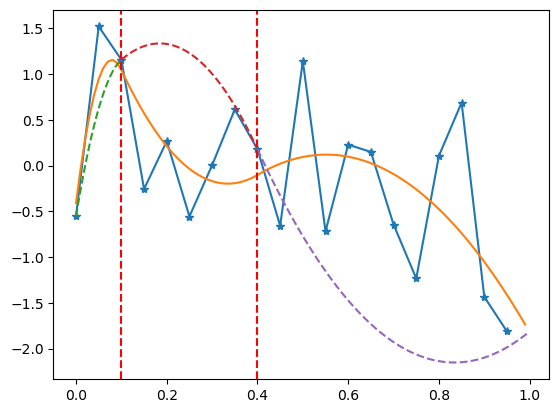

In [12]:
n_bkps = 2
model.predict(n_bkps)
approx_8, spl = compute_prediction(signal, model.bkps)
residual_norm = np.linalg.norm(signal - approx_8)
print(f"{ n_bkps = }\tResidual norm: {residual_norm:.4f}")
plt.plot(x, signal, "-*", label="Observed Signal")
xx = np.linspace(0, 1, 100, False)
plt.plot(xx, spl(xx).squeeze())
plot_approx_of_op(signal, model.bkps.tolist(), v=speeds[0, 0])
for b in model.bkps:
    plt.axvline(b / signal.shape[0], color="red", linestyle="--", label="Breakpoint")
# plt.ylim(-1, 20)
print(f"Breakpoints: {model.bkps}")

 n_bkps = 4	Residual norm: 2.6713
Breakpoints: [ 2  6 12 13]


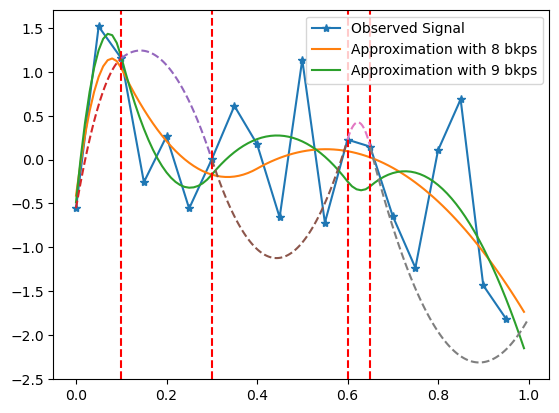

In [13]:
plt.plot(x, signal, "-*", label="Observed Signal")
plt.plot(xx, spl(xx).squeeze(), label="Approximation with 8 bkps")

n_bkps = 4
model.predict(n_bkps)
approx_9, spl = compute_prediction(signal, model.bkps)
residual_norm = np.linalg.norm(signal - approx_9)
print(f"{ n_bkps = }\tResidual norm: {residual_norm:.4f}")
xx = np.linspace(0, 1, 100, False)
plt.plot(xx, spl(xx).squeeze(), label="Approximation with 9 bkps")
for b in model.bkps:
    plt.axvline(b / signal.shape[0], color="red", linestyle="--")
# plt.ylim(-1, 20)
print(f"Breakpoints: {model.bkps}")
plot_approx_of_op(signal, model.bkps.tolist(), v=speeds[0, 0])
plt.legend()

 n_bkps = 7	Residual norm: 2.4757
Breakpoints: [ 3  5  7 13 14 15 18]


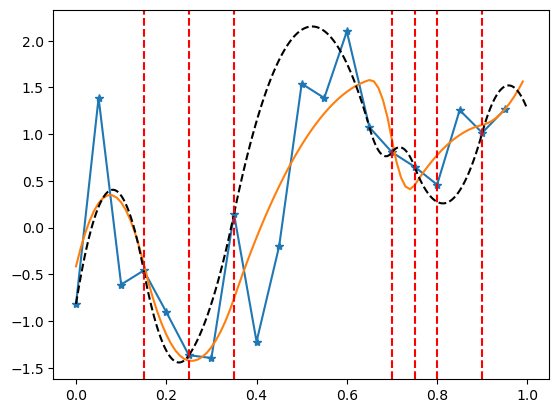

In [ ]:
bkps = np.array([3, 5, 7, 13, 14, 15, 18])
approx, spl = compute_prediction(signal, bkps)
residual_norm = np.linalg.norm(signal - approx)
print(f"{ n_bkps = }\tResidual norm: {residual_norm:.4f}")
plt.plot(x, signal, "-*", label="Observed Signal")
xx = np.linspace(0, 1, 100, False)
plt.plot(xx, spl(xx).squeeze())
plot_approx_of_op(signal, bkps.tolist(), v=speeds[0, 0])
for b in model.bkps:
    plt.axvline(b / signal.shape[0], color="red", linestyle="--", label="Breakpoint")
# plt.ylim(-1, 20)
print(f"Breakpoints: {bkps}")

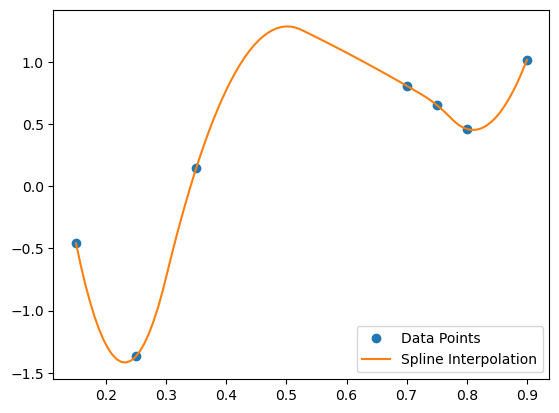

array(-67.23762882)

In [ ]:
from scipy.interpolate import make_interp_spline

# Example data: 10 pairs (x, y)
x = np.linspace(0, 1, signal.shape[0], endpoint=False)[model.bkps]
y = signal[model.bkps].squeeze()

# Fit a spline that goes through all points
spline = make_interp_spline(x, y, k=2)  # k=3 for cubic spline

# Evaluate spline on a fine grid for smooth plot
xx = np.linspace(x.min(), x.max(), 100)
yy = spline(xx)

plt.plot(x, y, 'o', label='Data Points')
plt.plot(xx, yy, '-', label='Spline Interpolation')
plt.legend()
plt.show()
spline.derivative()(0)

 n_bkps = 6	Residual norm: 1.8892
Breakpoints: [2, 3, 4, 9, 13, 15]


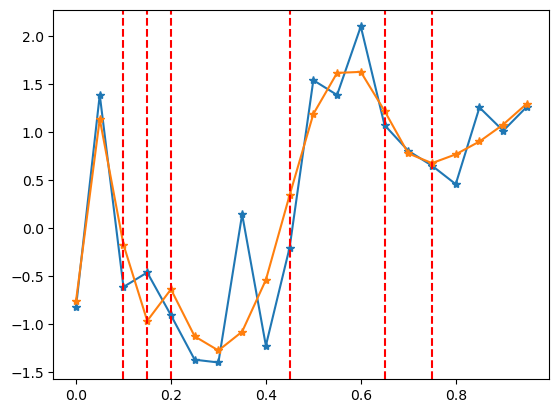

In [19]:
bkps = [2, 3, 4, 9, 13, 15]
approx, spl = compute_prediction(signal, bkps)
residual_norm = np.linalg.norm(signal - approx)
print(f"{ n_bkps = }\tResidual norm: {residual_norm:.4f}")
plt.plot(x, signal, "-*", label="Observed Signal")
plt.plot(x, approx, "-*", label="Approximation")
for b in bkps:
    plt.axvline(b / signal.shape[0], color="red", linestyle="--", label="Breakpoint")

print(f"Breakpoints: {bkps}")

In [ ]:
for i in range(1, 18):
    for j in range(i+1, 18):
        # Your code here, e.g. print(i, j)
        bkps = [i, j]
        approx, spl = compute_prediction(signal, bkps)
        residual_norm = np.linalg.norm(signal - approx)
        print(f"{bkps = }\tResidual norm: {residual_norm:.4f}")

bkps = [1, 2]	Residual norm: 3.9752
bkps = [1, 3]	Residual norm: 3.9825
bkps = [1, 4]	Residual norm: 3.9797
bkps = [1, 5]	Residual norm: 3.9693
bkps = [1, 6]	Residual norm: 3.9455
bkps = [1, 7]	Residual norm: 3.9106
bkps = [1, 8]	Residual norm: 3.8964
bkps = [1, 9]	Residual norm: 3.8994
bkps = [1, 10]	Residual norm: 3.8849
bkps = [1, 11]	Residual norm: 3.8326
bkps = [1, 12]	Residual norm: 3.7472
bkps = [1, 13]	Residual norm: 3.6619
bkps = [1, 14]	Residual norm: 3.6426
bkps = [1, 15]	Residual norm: 3.7137
bkps = [1, 16]	Residual norm: 3.8048
bkps = [1, 17]	Residual norm: nan
bkps = [2, 3]	Residual norm: 3.9720
bkps = [2, 4]	Residual norm: 3.9762
bkps = [2, 5]	Residual norm: 3.9698
bkps = [2, 6]	Residual norm: 3.9468
bkps = [2, 7]	Residual norm: 3.9110
bkps = [2, 8]	Residual norm: 3.8974
bkps = [2, 9]	Residual norm: 3.9014
bkps = [2, 10]	Residual norm: 3.8871
bkps = [2, 11]	Residual norm: 3.8347
bkps = [2, 12]	Residual norm: 3.7489
bkps = [2, 13]	Residual norm: 3.6637
bkps = [2, 14]	Resi

# Plot prediction

In [ ]:
x = np.linspace(0,1,1000,False) # Support for the prediction
b = np.array(model.bkps/1000) # Convert to [0,1] scale; i.e. 1000 = number of samples

# Generate knots from change points
## Knots for the spline require addition of extreme points
## to ensure smoothness
t = np.hstack(
        (np.array([0, 0, 0]), b)
    ) 
t = np.hstack((t, np.array([1, 1, 1]))) 

# Compute predicted polynomial
predicted_polynomial = make_lsq_spline(x=x,
                                        y=y_obs,
                                        t=t,
                                        k=2)

[]

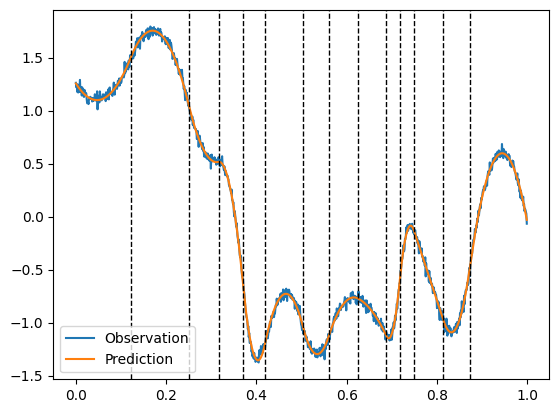

In [ ]:
f, ax = plt.subplots()
ax.plot(x,y_obs, label="Observation")
ax.plot(x,predicted_polynomial(x), label="Prediction")
for bkp in b:
    ax.axvline(bkp,ls="--", color='k',lw=1)
plt.legend()
plt.plot()